<a href="https://colab.research.google.com/github/Bazyarmostafa/DS-capstone-project/blob/main/MainFunctions_(11).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip  install html5lib
!python -m pip install --upgrade html5lib
!python -m pip install --upgrade html5lib
!pip install nbimporter
!pip install binance-connector
!pip install mplfinance
! pip install pandas numpy scikit-learn yfinance matplotlib
! pip install xgboost

# Install TA-Lib C library
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..

# Install the Python wrapper
!pip install ta-lib
! pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


In [8]:
# import necessary information
import requests
import pandas as pd
import lxml
import html5lib
import json
import time
from binance.spot import Spot
from binance.spot import Spot as Client
from IPython.display import clear_output
import matplotlib.pyplot as plt
import mplfinance as mpf
from IPython.display import clear_output
import numpy as np
from scipy.stats import gaussian_kde
from typing import Tuple, Dict
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import talib

In [11]:



# for 1 minutes
url2='https://data-api.coindesk.com/index/cc/v1/historical/minutes?market=cadli&instrument=BTC-USD&limit=2000&aggregate=1&fill=true&apply_mapping=true&response_format=JSON'

# for 10 minutes
url3='https://data-api.coindesk.com/index/cc/v1/historical/minutes?market=cadli&instrument=BTC-USD&limit=200&aggregate=10&fill=true&apply_mapping=true&response_format=JSON'


# for hours:
url4='https://data-api.coindesk.com/index/cc/v1/historical/hours?market=cadli&instrument=BTC-USD&limit=2000&aggregate=1&fill=true&apply_mapping=true&response_format=JSON'


# for days (5000)
url5='https://data-api.coindesk.com/index/cc/v1/historical/days?market=cadli&instrument=BTC-USD&limit=5000&aggregate=1&fill=true&apply_mapping=true&response_format=JSON'



# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)


In [12]:
# get public information from nobitex

def nobbtcprice(symbol='BTCUSDT'):


    domain="https://api.nobitex.ir/v3/orderbook/"
    symbol=symbol
    url=domain+symbol
    a= requests.get(url)
    b=json.loads(a.text)
    table=[symbol,b['lastTradePrice']]
    return table


# get personal information from nobitex
def nobitexprofile(key):
    domain="https://api.nobitex.ir/users/profile"
    headers = {
    'Authorization': 'Token '+ key
                                         }

    a= requests.get(domain, headers=headers)
    b=json.loads(a.text)
    return b

# GET BALANCE
def nobitexbalance(key,currency):
    url="https://api.nobitex.ir/users/wallets/balance"
    headers = {
    'Authorization': 'Token '+ key,
    'Content-Type': 'application/json'
       }

    a= requests.post(url, headers=headers, json={'currency': currency})
    b=a.json()
    return b

def walletlist(key, type=None,currencies=None):
    domain='https://api.nobitex.ir/users/wallets/list'
    params={
        "type":type,
        "currencies": currencies

          }
    headers = {
        'Authorization': 'Token '+ key

                 }

    result=requests.post(domain,headers=headers,json=params)
    return result



# tEST ABOVE FUNCTIONS

key = "a0940187202957416a6ce930b278ffbd4e19623d"
c=nobitexbalance(key=key,currency='btc')['balance']
d=nobitexbalance(key=key,currency='usdt')['balance']
e=nobitexbalance(key=key,currency='ltc')['balance']
t=nobitexprofile(key=key)

spotwalet=walletlist(key=key,type='spot')
marginwalet=walletlist(key=key,type='margin')
totalrialofwallets=sum(pd.DataFrame(json.loads(spotwalet.text)["wallets"])['rialBalanceSell'])+sum(pd.DataFrame(json.loads(marginwalet.text)["wallets"])['rialBalanceSell'])

table= pd.DataFrame({'First Name':[t['profile']['firstName']],
              'LastName': [t['profile']['lastName']],
             'Btc balance ':[c],
             'Usdt balance ': [d],
             'Ltc balance ': [e],
             'Total balance in rials':[totalrialofwallets]
             }).reset_index(drop=True)
table

KeyboardInterrupt: 

In [ ]:
# do actions in Nobitex (cell and buy)
def order(key, type , srcCurrency ,dstCurrency,amount,price,clientOrderId="order432" , stopPrice=None,execution='limit',mode=None,stopLimitPrice=None ):
    domain='https://api.nobitex.ir/market/orders/add'
    params={
        "type":type,
        "srcCurrency":srcCurrency,
        "dstCurrency":dstCurrency,
        "amount":amount,
        "price":price,
        "clientOrderId":clientOrderId
          }
    headers = {
        'Authorization': 'Token '+ key

                 }

    result=requests.post(domain,headers=headers,json=params)
    return result

def orderStatus(id=None,clientOrderId=None):
    domain='https://api.nobitex.ir/market/orders/status'
    headers = {
    'Authorization': 'Token '+ key
                     }
    params={
        "id":id,
        "clientOrderId":clientOrderId
             }

    result=requests.post(domain,headers=headers,json=params)
    return result


def orderList(key,type='buy', status='all',execution='limit',tradeType='spot',srcCurrency='btc',dstCurrency='usdt',details=1,fromId=1,order='id'):
    domain='https://api.nobitex.ir/market/orders/list'
    headers = {
    'Authorization': 'Token '+ key
                     }
    params = {
        'key':key,
        'status': status,
        'type': type,
        'execution': execution,
        'tradeType': tradeType,
        'srcCurrency': srcCurrency,
        'dstCurrency': dstCurrency,
        'details': details,
        'fromId': fromId,
        'order': order
            }
    result=requests.post(domain,headers=headers,json=params)
    # result=json.loads(result.text)
    return result


def orderCancel(clientOrderId,orderid=None, status='canceled'):
    domain='https://api.nobitex.ir/market/orders/update-status'
    headers = {
         'Authorization': 'Token '+ key
                     }
    params = {
        'order':orderid,
        "clientOrderId":clientOrderId,
        'status': status,
            }
    result=requests.post(domain,headers=headers,json=params)
    # result=json.loads(result.text)
    return result


# Test above functions
price=9900000
clientOrderId="3434"
a=order(key=key, type='sell', srcCurrency='btc', dstCurrency='usdt', amount=0.000094, price=price, clientOrderId=clientOrderId)
if a.status_code==200:
    print("order sent" )
else:
    print("error order sent")
b=orderStatus(clientOrderId=clientOrderId)
if b.status_code==200:
    print("order status")
    print(json.loads(b.text)['order'])
else:
    print("error order status")
c=orderCancel(clientOrderId=clientOrderId)
if c.status_code==200:
    print("order calnceled")
    print(json.loads(c.text))
else:
    print("error orderCancel" )
t=orderList(key=key,type='sell',status='done', tradeType='margin')
if t.status_code==200:
    print("order list:")
    result=json.loads(t.text)
    # pd.DataFrame(result['orders'])
    t=result['orders']
    # print(result['orders'])
    print(pd.DataFrame(t))
else:
    print("error orderList")

NameError: name 'key' is not defined

In [13]:
# def fetch_market_data(): # get international data
def fetch_last_price(url):
    # url='https://min-api.cryptocompare.com/data/price?fsym=BTC&tsyms=USD'
    return json.loads(requests.get(url).text)['USD']



def fetch_OHLCV(url):
    result=json.loads(requests.get(url).text)
    rowTable=pd.DataFrame(result['Data'])
    df=rowTable[['TIMESTAMP','OPEN', 'HIGH', 'LOW', 'CLOSE','VOLUME']]


    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
    df.set_index('TIMESTAMP', inplace=True)
    df.columns=['Open', 'High', 'Low', 'Close','Volume']
    return df



df=fetch_OHLCV(url4)
df





<ipython-input-13-8ab3183375ec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])


,Open,High,Low,Close,Volume
TIMESTAMP,,,,,
1970-01-01 00:00:01.739077200,97248.699221,97252.370622,97033.983224,97059.994598,3098.998909
1970-01-01 00:00:01.739080800,97059.994598,97095.597460,96814.526588,97035.414209,4094.555929
1970-01-01 00:00:01.739084400,97035.414209,97200.149636,96962.338809,97108.869541,3202.859991
1970-01-01 00:00:01.739088000,97108.869541,97342.886855,97108.610451,97162.403399,4165.148313
1970-01-01 00:00:01.739091600,97162.403399,97166.437137,96932.212275,96952.801624,4566.156065
...,...,...,...,...,...
1970-01-01 00:00:01.746259200,96381.492772,96474.373569,96203.528337,96344.145776,6017.840073
1970-01-01 00:00:01.746262800,96344.145776,96447.815987,96249.291815,96310.710992,3947.861008
1970-01-01 00:00:01.746266400,96310.710992,96310.710992,95933.953527,95958.309137,8583.570021


<!-- Convert intraday data to daily OHLCV candles -->

Convert intraday data to daily OHLCV candles

In [14]:
        # Convert intraday data to daily OHLCV candles
def resample(df,period):
   try:
                df.columns=['OPEN', 'HIGH', 'LOW', 'CLOSE','VOLUME']
                # df.setindex=df['TIMESTAMP']
                raw_df = df[~df.index.duplicated(keep='first')]  # Remove duplicate timestamps

                raw_df = raw_df.sort_index()  # Ensure chronological order
                        # Define aggregation rules for OHLCV
                ohlcv_rules = {
                        'OPEN': 'first',  # First price in 24h period
                        'HIGH': 'max',    # Highest price in 24h
                        'LOW': 'min',     # Lowest price in 24h
                        'CLOSE': 'last',  # Last price in 24h
                        'VOLUME': 'sum'   # Total volume in 24h
                                }
                # raw_df.set_index('TIMESTAMP', inplace=True)
                ohlcv_df = raw_df.resample(period).agg(ohlcv_rules)
                return ohlcv_df
   except:
                return KeyError



<h2> <b> Market Structure Analyzer </b></h2>

<p>Support/Resistance Analyzer
Integrates Fractal Detection, Fibonacci Retracements, and Volume-Weighted Pivot Points


In [15]:
class MarketStructureAnalyzer:
    def __init__(self, fractal_period: int = 5, fib_levels: list = None,
                 atr_period: int = 14, merge_tolerance_pct: float = 1.5):
        """
        # Input:
        #   fractal_period (int): Window for fractal detection (odd >=5)
        #   fib_levels (list): Fibonacci retracement levels (0-1)
        #   atr_period (int): Period for volatility normalization
        #   merge_tolerance_pct (float): Level merging tolerance (% of price)
        # Output: Initialized analyzer instance
        """
        self.fractal_period = max(5, fractal_period | 1)  # Ensure odd number
        self.fib_levels = fib_levels or [0.236, 0.382, 0.5, 0.618, 0.786]
        self.atr_period = atr_period
        self.merge_tol_pct = merge_tolerance_pct
        self._validate_parameters()



    def calculate_levels(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        # Input: ohlcv_df (pd.DataFrame), shape=(n,5), cols=['open','high','low','close','volume']
        # Output: levels_df (pd.DataFrame), cols=['price','strength','type','source']
        """
        ohlcv_df=df.copy()
        ohlcv_df.columns=['open','high','low','close','volume']
        self._validate_data(ohlcv_df)

        # Calculate volatility-normalized merge tolerance
        atr = self._calculate_atr(ohlcv_df)
        merge_tolerance = ohlcv_df['close'].iloc[-1] * (self.merge_tol_pct / 100)

        # Multi-method level detection
        fractal_levels = self._detect_fractal_levels(ohlcv_df)
        fib_levels = self._calculate_fibonacci_levels(ohlcv_df, fractal_levels)
        pivot_levels = self._calculate_volume_pivots(ohlcv_df)
        cluster_levels = self._find_volume_clusters(ohlcv_df)
        # Combine and filter levels
        combined = np.concatenate([fractal_levels, fib_levels, pivot_levels, cluster_levels])
        merged_levels = self._merge_price_levels(combined, merge_tolerance)

        return self._create_output_dataframe(ohlcv_df, merged_levels, atr)

    def _validate_parameters(self):
        """Ensure parameter sanity"""
        if not all(0 < lvl < 1 for lvl in self.fib_levels):
            raise ValueError("Fibonacci levels must be between 0 and 1")
        if self.merge_tol_pct <= 0:
            raise ValueError("Merge tolerance must be positive")

    def _validate_data(self, df: pd.DataFrame):
        """OHLCV data integrity checks"""
        required = ['open', 'high', 'low', 'close', 'volume']
        if not set(required).issubset(df.columns):
            raise ValueError(f"Missing required columns: {required}")
        if df.shape[0] < max(2*self.fractal_period, self.atr_period):
            raise ValueError("Insufficient data points for analysis")
        if df.isnull().values.any():
            raise ValueError("Input data contains NaN values")










    def _detect_fractal_levels(self, df: pd.DataFrame) -> np.ndarray:
        """
        # Input: df (pd.DataFrame), validated OHLCV data
        # Output: fractals (np.array), shape=(k,), fractal levels
        """
        half_window = self.fractal_period // 2
        highs = df['high'].values
        lows = df['low'].values

        # Detect fractal highs (peak with n periods before/after)
        fractal_highs = []
        for i in range(half_window, len(highs)-half_window):
            if highs[i] == max(highs[i-half_window:i+half_window+1]):
                fractal_highs.append(highs[i])

        # Detect fractal lows (trough with n periods before/after)
        fractal_lows = []
        for i in range(half_window, len(lows)-half_window):
            if lows[i] == min(lows[i-half_window:i+half_window+1]):
                fractal_lows.append(lows[i])

        return np.concatenate([fractal_highs, fractal_lows])




    def _calculate_fibonacci_levels(self, df: pd.DataFrame, fractals: np.ndarray) -> np.ndarray:
        """
        # Input:
        #   df (pd.DataFrame), validated OHLCV
        #   fractals (np.array), detected fractal levels
        # Output: fib_levels (np.array), shape=(m,)
        """
        if len(fractals) < 2:
            return np.array([])

        # Find most significant swing points
        recent_high = df['high'].iloc[-self.fractal_period*2:].max()
        recent_low = df['low'].iloc[-self.fractal_period*2:].min()
        price_range = recent_high - recent_low

        return np.array([recent_high - lvl*price_range for lvl in self.fib_levels])





    def _calculate_volume_pivots(self, df: pd.DataFrame) -> np.ndarray:
        """
        # Input: df (pd.DataFrame), validated OHLCV
        # Output: pivots (np.array), shape=(3,), [pivot, support1, resistance1]
        """
        # Traditional floor pivots with volume weighting
        prev = df.iloc[-2]  # Use previous period's values
        pivot = (prev['high'] + prev['low'] + prev['close']) / 3
        s1 = (2 * pivot) - prev['high']
        r1 = (2 * pivot) - prev['low']

        # Current period volume influence
        current_volume = df['volume'].iloc[-1]
        volume_weight = current_volume / df['volume'].iloc[-10:].mean()

        return np.array([pivot, s1*(1 + volume_weight/100), r1*(1 - volume_weight/100)])


    def calculate_volume_profile(self,df: pd.DataFrame, bins=200):
        """Calculate volume profile with price distribution"""
        price_min = df['Low'].min()
        price_max = df['High'].max()
        bins = np.linspace(price_min, price_max, bins)
        bin_centers = (bins[:-1] + bins[1:])/2
        volume_profile = np.zeros_like(bin_centers)

        for _, row in df.iterrows():
            low, high, vol = row[['Low', 'High', 'Volume']]
            valid_bins = (bin_centers >= low) & (bin_centers <= high)
            if valid_bins.any():
                portion = vol / valid_bins.sum()
                volume_profile[valid_bins] += portion

        return bin_centers.flatten(), volume_profile.flatten()





    def _find_volume_clusters(self, df: pd.DataFrame, num_clusters: int = 4) -> np.ndarray:
        """
        # Input: df (pd.DataFrame), validated OHLCV
        # Output: clusters (np.array), shape=(q,)
        """
        # Kernel density estimation with volume weights
        kde = gaussian_kde(df['close'], weights=df['volume'])
        x = np.linspace(df['low'].min(), df['high'].max(), 500)
        y = kde(x)

        # Find density peaks
        peaks = x[np.argsort(y)[-num_clusters:]]
        return peaks





    def _merge_price_levels(self, levels: np.ndarray, tolerance: float) -> np.ndarray:
        """
        # Input:
        #   levels (np.array), raw price levels
        #   tolerance (float), merge threshold
        # Output: merged_levels (np.array), shape=(r,)
        """
        if len(levels) == 0:
            return np.array([])

        sorted_levels = np.sort(levels)
        clusters = []
        current_cluster = [sorted_levels[0]]

        for lvl in sorted_levels[1:]:
            if lvl - current_cluster[-1] <= tolerance:
                current_cluster.append(lvl)
            else:
                clusters.append(np.mean(current_cluster))
                current_cluster = [lvl]

        if current_cluster:
            clusters.append(np.mean(current_cluster))

        return np.array(clusters)

    def _create_output_dataframe(self, df: pd.DataFrame, levels: np.ndarray,
                               atr: float) -> pd.DataFrame:
        """Create final categorized output"""
        if len(levels) == 0:
            return pd.DataFrame(columns=['price', 'strength', 'type', 'source'])

        current_price = df['close'].iloc[-1]
        strength = np.linspace(1, 0.3, len(levels))

        levels_df = pd.DataFrame({
            'price': levels,
            'strength': strength,
            'type': np.where(levels < current_price, 'support', 'resistance'),
            'volatility': atr
        })

        return levels_df.sort_values('price').reset_index(drop=True)







    def _calculate_atr(self, df: pd.DataFrame) -> float:



#         """Average True Range for volatility measurement
# ``
#         Calculate Average True Range

#         Input:
#         - prices: Pandas Series
#         - window: Smoothing period

#         How it works:
#         1. Calculate True Range
#         2. Apply EMA smoothing

#         Output:
#         - Pandas Series of ATR values
#         """
#         prices=df['close']
#         high_low = prices - prices.shift(1)
#         high_close = abs(prices - prices.shift(1))
#         low_close = abs(prices.shift(1) - prices)

#         tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
#         return self.calculate_ema(tr.dropna(), 14)




        # ####################
        high, low, close = df['high'], df['low'], df['close']
        tr = np.maximum(high - low,
                       np.maximum(abs(high - close.shift()),
                                 abs(low - close.shift())))
        return tr.rolling(self.atr_period).mean().iloc[-1]


    # def calculate_ema(self,prices, window):
    #     """
    #     Calculate Exponential Moving Average

    #     Input:
    #     - prices: Pandas Series
    #     - window: Smoothing period (int)

    #     How it works:
    #     1. Uses smoothing factor α = 2/(window+1)
    #     2. Recursively weights recent prices higher

    #     Output:
    #     - Pandas Series of EMA values
    #     """
    #     alpha = 2 / (window + 1)
    #     return prices.ewm(alpha=alpha, adjust=False).mean()



    def visualize_levels(self,url, df: pd.DataFrame, levels_df: pd.DataFrame,
                       days_window: int = 30) -> plt.Figure:
        """
        # Input:
        #   df (pd.DataFrame), original OHLCV data
        #   levels_df (pd.DataFrame), calculated levels
        #   days_window (int), visualization period
        # Output: matplotlib.figure.Figure
        """
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(14, 7))
        df.columns=['open','high','low','close','volume']
        # Price plot
        ax.plot(df['close'].iloc[-days_window:], color='royalblue', lw=1.5, label='Price')
        ax.plot(df['close'].index[-1],fetch_last_price(url), color='red', marker='o',markersize=8, markeredgecolor='black', markerfacecolor='white',  linestyle='', label='last_Price')



        # Support/resistance zones
        for _, row in levels_df.iterrows():
            color = 'forestgreen' if row['type'] == 'support' else 'firebrick'
            alpha = pow(row['strength'],1.2) * 0.9
            ax.axhline(row['price'], color=color, linestyle='--', alpha=alpha,
                      label=f"{row['type'].title()} , strength: {round(row['strength'],2)}")

        # Formatting
        ax.set_title(f"Market Structure Analysis\nVolatility: {levels_df['volatility'].iloc[0]:.2f} ATR")
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend()
        plt.tight_layout()

        return fig

data=fetch_OHLCV(url2)
model=MarketStructureAnalyzer(fractal_period=5,
            merge_tolerance_pct=0.05,
            fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
                            )
b=model.calculate_levels(data)
b



<ipython-input-13-8ab3183375ec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])


,price,strength,type,volatility
0,96023.089689,1.000,support,16.225928
1,96754.847701,0.825,resistance,16.225928
2,97572.021020,0.650,resistance,16.225928
3,97843.330215,0.475,resistance,16.225928
4,97938.365995,0.300,resistance,16.225928


<h2> Technical analysis methods </h2>

<p font-size: 12; ">
    1- Moving Averages (EMA + SMA)

        Parameters:

        Short-term: 20-day EMA (fast), 50-day SMA (slow).

        Mid-term: 50-day EMA (fast), 200-day SMA (slow).

        How to Use:

        Trend Direction: Price above EMA/SMA = uptrend; below = downtrend.
        Crossover Signals:
        Golden Cross: 20-day EMA crosses above 50-day SMA → bullish.
        Death Cross: 20-day EMA crosses below 50-day SMA → bearish.
        Dynamic Support/Resistance: Price often retests EMA/SMA in trends.
        Best For: Filtering trades in the direction of the trend.

    2. Relative Strength Index (RSI)
        Parameters: 14-period RSI (default).

        How to Use:

        Overbought/Oversold:

        RSI >70 → potential sell (overbought).

        RSI <30 → potential buy (oversold).

        Divergence:

        Bullish Divergence: Price makes lower lows, RSI makes higher lows → reversal up likely.

        Bearish Divergence: Price makes higher highs, RSI makes lower highs → reversal down likely.

        Best For: Timing entries in trending markets and spotting reversals.

    3. MACD (Moving Average Convergence Divergence)
        Parameters: 12, 26, 9 (default).

        How to Use:

        Signal Line Cross:

        MACD line (blue) crosses above signal line (orange) → buy.

        MACD line crosses below signal line → sell.

        Zero Line Cross:

        MACD crosses above zero → bullish momentum.

        MACD crosses below zero → bearish momentum.

        Histogram: Height shows momentum strength.

        Best For: Confirming trend changes and momentum shifts.

    4. Bollinger Bands
        Parameters: 20-day SMA + 2 standard deviations.

        How to Use:

        Volatility Signals:

        Squeeze: Bands narrow → volatility buildup → expect breakout.

        Expansion: Bands widen → strong trend continuation.

        Reversals:

        Price touches upper band → overbought (sell in downtrend).

        Price touches lower band → oversold (buy in uptrend).

        Best For: Identifying breakout opportunities and mean-reversion trades.

    5. Volume Analysis
        Key Tools:

        On-Balance Volume (OBV): Rising OBV confirms uptrends; falling OBV signals weakness.

        Volume Spikes: Sudden surges often precede big price moves (e.g., breakouts).

        How to Use:

        Confirmation: Rising price + rising volume = valid trend.

        Divergence: Price up + volume down → weak trend (caution).

        Best For: Validating trend strength and spotting institutional activity.

    6. Fibonacci Retracement
        Key Levels: 23.6%, 38.2%, 50%, 61.8%.

        How to Use:

        Pullback Entries: Buy near 38.2% or 61.8% retracement levels in uptrends.

        Profit Targets: Use 161.8% or 261.8% extensions for take-profit zones.

        Support/Resistance: Price often reverses at Fibonacci levels.

        Best For: Timing entries in trending markets and setting profit targets.

</p>


In [ ]:
# ema_fast = techmethods().calculate_ema(data['Close'],5)
# ema_slow = techmethods().calculate_ema(data['Close'],120)

# macd_line = ema_fast - ema_slow
# signal_line = techmethods().calculate_ema(macd_line.dropna(), 60)

#         # # Align indices
#         # macd_line = macd_line[signal_line.index[0]:]
#         # histogram = macd_line - signal_line

#         # return macd_line, signal_line, histogram

# a,b,c=techmethods().calculate_macd(prices=data['Close'])

# plt.plot(ema_fast)
# plt.plot(ema_slow)
# plt.plot(macd_line)
# plt.plot(signal_line)

In [16]:
class techmethods:


    def calculate_sma(self,prices: pd.Series, window: int) -> pd.Series:

        """
        Calculate Simple Moving Average

        Input:
        - prices: Pandas Series of closing prices
        - window: Lookback period (int)

        How it works:
        1. Creates a rolling window
        2. Calculates mean for each window

        Output:
        - Pandas Series of SMA values
        """
        result=prices.rolling(window=window).mean()
        return result


    def calculate_atr(self,prices, window=14):
        """
        Calculate Average True Range

        Input:
        - prices: Pandas Series
        - window: Smoothing period

        How it works:
        1. Calculate True Range
        2. Apply EMA smoothing

        Output:
        - Pandas Series of ATR values
        """
        high_low = prices - prices.shift(1)
        high_close = abs(prices - prices.shift(1))
        low_close = abs(prices.shift(1) - prices)

        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        return self.calculate_ema(tr.dropna(), window)


    def calculate_ema(self,prices, window):
        """
        Calculate Exponential Moving Average

        Input:
        - prices: Pandas Series
        - window: Smoothing period (int)

        How it works:
        1. Uses smoothing factor α = 2/(window+1)
        2. Recursively weights recent prices higher

        Output:
        - Pandas Series of EMA values
        """
        alpha = 2 / (window + 1)
        return prices.ewm(alpha=alpha, adjust=False).mean()



    def calculate_kama(self,prices, er_window=10, fast_ema=2, slow_ema=30):
        """
        Kaufman's Adaptive Moving Average

        Input:
        - prices: Pandas Series
        - er_window: Efficiency ratio period
        - fast_ema/slow_ema: EMA periods

        How it works:
        1. Calculate Efficiency Ratio (ER)
        2. Compute smoothing constant SC
        3. Recursively apply adaptive smoothing

        Output:
        - Pandas Series of KAMA values
        """
            # Check if prices has enough data
        if len(prices) < er_window:
             raise ValueError("Not enough data points to calculate KAMA.")
        prices = prices.copy()
        change = abs(prices - prices.shift(er_window))
        volatility = prices.diff().abs().rolling(er_window).sum()

        # Efficiency Ratio calculation
        er = change / (volatility + 1e-10)  # Prevent division by zero

        # Smoothing constants
        fast_alpha = 2 / (fast_ema + 1)
        slow_alpha = 2 / (slow_ema + 1)
        sc = (er * (fast_alpha - slow_alpha) + slow_alpha) ** 2

        # Initialize KAMA
        kama = [prices.iloc[0]]  # Seed with first price

        for i in range(1, len(prices)):
            if pd.isna(sc.iloc[i]):  # Check if SC is NaN
                kama.append(kama[-1])  # Carry forward the last KAMA value
            else:
                current_kama = kama[-1] + sc.iloc[i] * (prices.iloc[i] - kama[-1])
                kama.append(current_kama)

        return pd.Series(kama, index=prices.index)

    def calculate_rsi(self, prices, rsi_window=14, volatility_window=14):
        """
        Volatility-Adjusted RSI

        Input:
        - prices: Pandas Series
        - rsi_window: RSI period
        - volatility_window: Volatility period

        How it works:
        1. Calculate standard RSI components
        2. Compute rolling volatility
        3. Adjust thresholds dynamically

        Output:
        - Tuple of (RSI values, upper_band, lower_band)
        """
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        # Smooth using Wilder's method
        avg_gain = gain.ewm(alpha=1/rsi_window, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/rsi_window, adjust=False).mean()

        # RSI calculation
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))

        # Volatility adjustment
        volatility = prices.pct_change().rolling(volatility_window).std()
        upper_band = 70 - (volatility * 100)
        lower_band = 30 + (volatility * 100)

        return rsi, upper_band, lower_band



    def calculate_macd(self,prices, fast=6, slow=26, signal=9)-> tuple:
        """
        Manual MACD Calculation

        Input:
        - prices: Pandas Series
        - fast/slow: EMA periods
        - signal: Signal line EMA

        How it works:
        1. Calculate fast and slow EMAs
        2. Compute MACD line (fast - slow)
        3. Create signal line (EMA of MACD)

        Output:
        - Tuple of (MACD line, signal line, histogram)
        """
        ema_fast = self.calculate_ema(prices, fast)
        ema_slow = self.calculate_ema(prices, slow)

        macd_line = ema_fast - ema_slow
        signal_line = self.calculate_ema(macd_line.dropna(), signal)

        # Align indices
        macd_line = macd_line[signal_line.index[0]:]
        histogram = macd_line - signal_line

        return macd_line, signal_line, histogram




    def calculate_bollinger_bands(self,prices, window=20, num_std=2):
        """
        Bollinger Bands with Squeeze Detection

        Input:
        - prices: Pandas Series
        - window: SMA period
        - num_std: Standard deviation multiplier

        How it works:
        1. Calculate SMA and rolling standard deviation
        2. Compute upper/lower bands
        3. Calculate squeeze ratio

        Output:
        - Tuple of (upper_band, lower_band, squeeze_ratio)
        """
        sma = self.calculate_sma(prices, window)
        std = prices.rolling(window).std()

        upper_band = sma + (std * num_std)
        lower_band = sma - (std * num_std)

        # Calculate Keltner Channels for squeeze
        atr = self.calculate_atr(prices, window)  # Defined later
        ema=self.calculate_ema(prices, window)
        def_m=1.5
        keltner_upper = ema + (atr * def_m)
        keltner_lower = ema - (atr * def_m)
        keltner_width = keltner_upper - keltner_lower
        keltner_width = keltner_width.replace(0, float('nan'))
        squeeze_ratio = (upper_band - lower_band) / (keltner_width)

        return upper_band, lower_band, squeeze_ratio

    def calculate_volume_indicators(self,prices, volume, obv_window=21):
        """
        Volume Analysis System

        Input:
        - prices: Pandas Series
        - volume: Trading volume data
        - obv_window: Smoothing period

        How it works:
        1. Calculate raw OBV
        2. Create smoothed OBV
        3. Detect volume spikes

        Output:
        - Tuple of (OBV, OBV_smooth, spike_signal)
        """
        # On-Balance Volume calculation

        obv = (np.sign(prices.diff()) * volume).cumsum()

        # Smooth OBV
        obv_smooth = obv.rolling(obv_window).mean()

        # Volume spike detection
        z_scores = (volume - volume.rolling(50).mean()) / volume.rolling(50).std()
        spike_signal = z_scores > 2  # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     3 standard deviations

        return obv, obv_smooth, spike_signal

    def calculate_fib_levels(self,prices, lookback=60):
        """
        Fibonacci Retracement Levels

        Input:
        - prices: Pandas Series
        - lookback: Period to find swing high/low

        How it works:
        1. Find recent swing high/low
        2. Calculate price differences
        3. Compute Fibonacci levels

        Output:
        - Dict of Fibonacci levels
        """
        # lookback = int(len(prices)*0.1)
        recent_prices = prices[-lookback-1:-1]
        # recent_prices = prices[-lookback:]
        swing_high = recent_prices.max()
        swing_low = recent_prices.min()
        diff = swing_high - swing_low

        return {
            '23.6%': swing_high - diff * 0.236,
            '38.2%': swing_high - diff * 0.382,
             '50%': (swing_high + swing_low)/2,
            '61.8%': swing_high - diff * 0.618
        }

    def calculate_fib_levels2(self, ohlcv_df,trend_bullish, lookback=60):
        """
        Calculate Fibonacci levels with automatic trend detection

        Parameters:
        - ohlcv_df: DataFrame with ['high', 'low', 'close'] columns
        - lookback: Number of periods to analyze (default: 60)

        Returns:
        - Dictionary of Fibonacci levels
        - Trend direction ('uptrend' or 'downtrend')
        """

        # Use historical data excluding current candle
        historical_data = ohlcv_df.iloc[-lookback-1:-1]

        # Trend detection logic
        swing_high = historical_data['High'].max()
        swing_low = historical_data['Low'].min()

        last_close = ohlcv_df['Close'].iloc[-2]  # Previous close price
        mid_price = (swing_high + swing_low) / 2

        # Determine trend direction
        trend = trend_bullish

        # Calculate price difference
        price_diff = swing_high - swing_low

        # Calculate Fibonacci levels based on trend
        if not trend :# 'downtrend'
            fib_levels = {
                '23.6%': swing_high - price_diff * 0.236,
                '38.2%': swing_high - price_diff * 0.382,
                '50%': (swing_high + swing_low) / 2,
                '61.8%': swing_high - price_diff * 0.618,
                '78.6%': swing_high - price_diff * 0.786
            }
        else:  # uptrend
            fib_levels = {
                '23.6%': swing_low + price_diff * 0.236,
                '38.2%': swing_low + price_diff * 0.382,
                '50%': (swing_high + swing_low) / 2,
                '61.8%': swing_low + price_diff * 0.618,
                '78.6%': swing_low + price_diff * 0.786
            }

        return fib_levels



    def calculate_position_size(self,account_balance, prices, risk_pct=0.01, atr_window=14):
        """
        Dynamic Position Sizing

        Input:
        - account_balance: Total capital
        - prices: Pandas Series
        - risk_pct: Risk per trade percentage
        - atr_window: ATR period

        How it works:
        1. Calculate Average True Range (ATR)
        2. Compute volatility adjustment
        3. Calculate position size

        Output:
        - Position size in units
        """
        atr = self.calculate_atr(prices, atr_window)
        volatility = prices.pct_change().std()

        return (account_balance * risk_pct) / (atr.iloc[-1] * volatility)


In [17]:
class TradingSystem:
    def __init__(self, prices,data, volume):
        self.prices = prices
        self.volume = volume
        self.ohlcv_df = data
        # Calculate all indicators
        self.kama = techmethods().calculate_kama(prices)
        self.rsi, self.rsi_upper, self.rsi_lower = techmethods().calculate_rsi(prices)
        self.macd_line, self.signal_line, self.histogram = techmethods().calculate_macd(prices)
        self.bb_upper, self.bb_lower, self.squeeze = techmethods().calculate_bollinger_bands(prices)
        self.obv, self.obv_smooth, self.spikes = techmethods().calculate_volume_indicators(prices, volume)
        self.fib_levels = techmethods().calculate_fib_levels(prices)

    def generate_signal(self,urlp):
        """
        Integrated Signal Generation

        How it works:
        1. Check trend condition
        2. Verify momentum
        3. Confirm with volume
        4. Validate with Fibonacci
        """
        current_price = fetch_last_price(urlp)
        # self.prices.iloc[-1]

        # Trend Condition
        trend_bullish = current_price > self.kama.iloc[-1]+200 #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> changed


        # Momentum Condition
        rsi_condition = self.rsi.iloc[-1] < self.rsi_lower.iloc[-1]+7
        macd_condition = self.histogram.iloc[-1] > 0

        # Volume Confirmation
        volume_condition = self.obv_smooth.iloc[-1] > self.obv_smooth.iloc[-2]

        # Fibonacci Level Check
        fib_38 = self.fib_levels['38.2%']
        fib_62 = self.fib_levels['61.8%']
        fib_condition = (current_price >= fib_38) and (current_price <= fib_62)

        # Bollinger Squeeze
        squeeze_condition = self.squeeze.iloc[-1] < 0.5
        print('trend_bullish:   buy:',trend_bullish, 'sell:  ',not trend_bullish )
        print('rsi:   buy>>>',rsi_condition,  'Sell>>>: ',self.rsi.iloc[-1] > self.rsi_upper.iloc[-1])
        print('macd condition:   buy>>>', macd_condition,'| Sell>>>:   ',self.histogram.iloc[-1] < 0)
        print('volume_condition:   buy>>>', volume_condition,'| Sell>>>:   ',self.obv_smooth.iloc[-1] < self.obv_smooth.iloc[-2])
        print('fib_condition:   buy>>>', fib_condition, '| Sell>>>:   ',((current_price) >= fib_38) or (current_price <= fib_62))
        print('squeeze_condition:   buy>>>', squeeze_condition)
        print('final>>', all([not trend_bullish,
                 self.rsi.iloc[-1] > self.rsi_upper.iloc[-1],
                 self.histogram.iloc[-1] < 0,
                 self.obv_smooth.iloc[-1] < self.obv_smooth.iloc[-2]]))
        print('informations>>>', 'RSI:',self.rsi.iloc[-1],'Price:',current_price)

        # Generate Final Signal
        if all([trend_bullish, rsi_condition, macd_condition,
                volume_condition, fib_condition, squeeze_condition]):
            return 'BUY'
        elif all([not trend_bullish,
                 self.rsi.iloc[-1] > self.rsi_upper.iloc[-1]-7,
                 self.histogram.iloc[-1] < 0,
                 self.obv_smooth.iloc[-1] < self.obv_smooth.iloc[-2]]):
            return 'SELL'
        else:
            return 'HOLD'



    def generate_light_signal(self):
        """
        Integrated Signal Generation

        How it works:
        1. Check trend condition
        2. Verify momentum
        3. Confirm with volume
        4. Validate with Fibonacci
        """
        last_close=current_price = self.prices[-1]# Previous close price

        ohlcv_df=self.ohlcv_df
        lookback=60  #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> sync it



        # Determine trend direction

        # Trend Condition
        trend_bullish = current_price > self.kama.iloc[-1]
        trend = 'uptrend' if last_close > self.kama.iloc[-1] else 'downtrend'

        # Use historical data excluding current candle
        # historical_data = ohlcv_df.iloc[-lookback-1:-1]




        # Momentum Condition
        rsi_condition = (self.rsi.iloc[-1] < self.rsi_lower.iloc[-1]+10) or (self.rsi.iloc[-1] > self.rsi_upper.iloc[-1]-10)
        macd_condition = self.histogram.iloc[-1] > 0

        # Volume Confirmation
        volume_condition = self.obv_smooth.iloc[-1] > self.obv_smooth.iloc[-2]

        # # Fibonacci Level Check
        # fib_38 = self.fib_levels['38.2%']
        # fib_62 = self.fib_levels['61.8%']
        # fib_condition = (current_price >= fib_38) and (current_price <= fib_62)


        # Fibonacci Level Check 2 >>>>>>>>>>>>>>>>>>>>>>>>>> ondition deleted
        fib_levels2 = techmethods().calculate_fib_levels2(ohlcv_df,trend_bullish=trend_bullish)





        fib_38 = fib_levels2['38.2%']
        fib_62 = fib_levels2['61.8%']
        fib_condition = (current_price >= fib_38) and (current_price <= fib_62)





        # Bollinger Squeeze

        squeeze_condition = self.squeeze.iloc[-1] < 1.5


        # Generate Final Signal >>>>>>>>>>>>>>>>>> Bollinger Squeeze condition deleted
        if all([trend_bullish, rsi_condition, macd_condition,
                volume_condition]):
            signal=1 # 'BUY'
        elif all([not trend_bullish,
                 rsi_condition,
                 self.histogram.iloc[-1] < 0,
                 self.obv_smooth.iloc[-1] < self.obv_smooth.iloc[-2]]):
            signal=-1 # 'Sell'
        else:
            signal=0 # 'Hold'

        columns=[['Time','price','Trend','bullish Trend','rsi buy condition','rsi','macd','Volume','Fib','Squeeze condition','Squeeze','Signal']]
        signaltable=pd.DataFrame([[ohlcv_df.index[-1],current_price,trend,trend_bullish,rsi_condition,self.rsi.iloc[-1],macd_condition,volume_condition,fib_condition,squeeze_condition,self.squeeze.iloc[-1], signal]],columns=columns)
        return signaltable

    def fulltable(self):
            """
            Integrated Table Generation

            How it works:
            1. Check trend condition
            2. Verify momentum
            3. Confirm with volume
            4. Validate with Fibonacci
            """
            last_close=current_price = self.prices[-1]# Previous close price

            ohlcv_df=self.ohlcv_df
            lookback=60  #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> sync it



            # Determine trend direction

            # Trend Condition
            trend_bullish = current_price > self.kama.iloc[-1]
            trend = 'uptrend' if last_close > self.kama.iloc[-1] else 'downtrend'

            # Use historical data excluding current candle
            # historical_data = ohlcv_df.iloc[-lookback-1:-1]




            # Momentum Condition
            rsi_condition = (self.rsi.iloc[-1] < self.rsi_lower.iloc[-1]+10) or (self.rsi.iloc[-1] > self.rsi_upper.iloc[-1]-10)
            macd_condition = self.histogram.iloc[-1] > 0

            # Volume Confirmation
            volume_condition = self.obv_smooth.iloc[-1] > self.obv_smooth.iloc[-2]




            # Fibonacci Level Check 2 >>>>>>>>>>>>>>>>>>>>>>>>>> ondition deleted
            fib_levels2 = techmethods().calculate_fib_levels2(ohlcv_df,trend_bullish=trend_bullish)





            fib_38 = fib_levels2['38.2%']
            fib_62 = fib_levels2['61.8%']
            fib_50 = fib_levels2['50%']
            fib_78 = fib_levels2['78.6%']





            fib_condition = (current_price >= fib_38) and (current_price <= fib_62)





            # Bollinger Squeeze

            squeeze_condition = self.squeeze.iloc[-1] < 1.5


            # Generate Final Signal >>>>>>>>>>>>>>>>>> Bollinger Squeeze condition deleted
            if all([trend_bullish, rsi_condition, macd_condition,
                    volume_condition]):
                signal=1 # 'BUY'
            elif all([not trend_bullish,
                    rsi_condition,
                    self.histogram.iloc[-1] < 0,
                    self.obv_smooth.iloc[-1] < self.obv_smooth.iloc[-2]]):
                signal=-1 # 'Sell'
            else:
                signal=0 # 'Hold'



            # columns=[['price','Trend','bullish Trend','rsi buy condition','rsi','macd condition','macd','Volume','obv_smooth[-1]','obv_smooth[-2]','Fib condition','fib38','fib50','fib62','fib78','Squeeze condition','Squeeze','Signal']]
            # signaltable=pd.DataFrame([[current_price,trend,trend_bullish,rsi_condition,self.rsi.iloc[-1],self.obv_smooth.iloc[-1],self.obv_smooth.iloc[-2],macd_condition,self.histogram.iloc[-1],volume_condition,fib_38,fib_50,fib_62,fib_78,,fib_condition,squeeze_condition,self.squeeze.iloc[-1], signal]],columns=columns)
            table={


                'price': current_price  ,
                'Trend': trend   ,
                'bullish Trend':trend_bullish ,
                'rsi buy condition': rsi_condition,
                'rsi':self.rsi.iloc[-1],
                'macd condition': macd_condition,
                'macd':self.histogram.iloc[-1] ,
                'volume_condition': volume_condition,
                'obv_smooth_1':self.obv_smooth.iloc[-1],
                'obv_smooth_2': self.obv_smooth.iloc[-2],
                'Fib condition':fib_condition,
                'fib_38' : fib_levels2['38.2%'],
                'fib_62' : fib_levels2['61.8%'],
                'fib_50' : fib_levels2['50%'],
                'fib_78' : fib_levels2['78.6%'],
                'Squeeze condition':squeeze_condition,
                'Squeeze':self.squeeze.iloc[-1],
                'bb_upper': self.bb_upper[-1],
                'bb_lower': self.bb_lower[-1],
                'Open': self.ohlcv_df.iloc[-1][0],
                'High': self.ohlcv_df.iloc[-1][1],
                'Low': self.ohlcv_df.iloc[-1][2],
                'Closed': self.ohlcv_df.iloc[-1][3],
                'Valume': self.ohlcv_df.iloc[-1][4],
                'Signal': signal,
                'Open': self.ohlcv_df.iloc[-1][0]



            }


            # table = pd.concat([pd.DataFrame(table,index=[0]), self.ohlcv_df.iloc[-1][0]])
            return pd.DataFrame(table,index=[0])



In [ ]:
# a,b,c=techmethods().calculate_bollinger_bands(data['Close'],window=20,num_std=2)
# plt.plot(a,linestyle='--',linewidth=0.15)
# plt.plot(b,linestyle='--',linewidth=0.15)

# plt.plot(data['Close'],linestyle='-',color='red',linewidth=0.05)
# # plt.plot(c)
# # c[1:50]>1
# # # data[:-21]
# quartiles = data.apply(row_quartiles, axis=1)
# quartiles['mean_Q1_Q3']
# master_table['mean_Q1_Q3']=data['mean_Q1_Q3']
# master_table
# data['mean_Q1_Q3']
# # data

In [131]:

# Function to calculate Q1 and Q3 for a row
def row_quartiles(row):
    q1 = np.percentile(row, 25)
    q3 = np.percentile(row, 75)
    return pd.Series({'mean_Q1_Q3': (q1+q3)/2})



# Join quartiles back to original dataframe if you want


# >>>>>>>>>>>>>>>>>>> a big table containing all featuers. should be modified for selectiong better features

def master_table_build(give_url,windows=100):

    result=[]
    master_table = pd.DataFrame()
    t=pd.DataFrame()
    # urlp='https://min-api.cryptocompare.com/data/price?fsym=BTC&tsyms=USD'
    data=fetch_OHLCV(give_url)
    # Apply the function row-wise on all columns (OHLCV)
    quartiles = data.apply(row_quartiles, axis=1)
    data = data.join(quartiles)
    for i in range(windows):
        ai=data['mean_Q1_Q3'].iloc[-(i-1)] if data['mean_Q1_Q3'].iloc[-(i-1)] is not None else 0

        # price=a=data['Close'].iloc[-(i-1)] if data['Close'].iloc[-(i-1)] is not None else 0 #>>> for future development price should be current price of market
        a=ai
        b=data['Close'].iloc[-(i-2)] if data['Close'].iloc[-(i-2)] is not None else 0
        b_high=data['High'].iloc[-(i-2)] if data['High'].iloc[-(i-2)] is not None else 0
        b_low=data['Low'].iloc[-(i-2)] if data['High'].iloc[-(i-2)] is not None else 0
        b_open=data['Open'].iloc[-(i-2)] if data['Open'].iloc[-(i-2)] is not None else 0
        c=data['Close'].iloc[-(i-3)] if data['Close'].iloc[-(i-3)] is not None else 0
        c_high=data['High'].iloc[-(i-3)] if data['High'].iloc[-(i-3)] is not None else 0
        c_low=data['Low'].iloc[-(i-3)] if data['Low'].iloc[-(i-3)] is not None else 0
        c_open=data['Open'].iloc[-(i-3)] if data['Open'].iloc[-(i-3)] is not None else 0
        d=data['Close'].iloc[-(i-4)] if data['Close'].iloc[-(i-4)] is not None else 0
        d_high=data['High'].iloc[-(i-4)] if data['High'].iloc[-(i-4)] is not None else 0
        d_low=data['Low'].iloc[-(i-4)] if data['Low'].iloc[-(i-4)] is not None else 0
        d_open=data['Open'].iloc[-(i-4)] if data['Open'].iloc[-(i-4)] is not None else 0

#>>>>> first next row trend (green or red) plus its power
        if b > b_open:
            tr=1
            b_trend = b_high - a
            # power = ( (b_high - a) / a)*30
            # power = max(power, 0)  # avoid negative power due to noise
            b_result= b_trend
        else:

                tr=0
                b_trend = b_low - a
                # power = ( (b_high - a) / a)*30
                # power = max(power, 0)  # avoid negative power due to noise
                b_result= b_trend

#>>>>> second next row trend (green or red) plus its power
        if c> c_open:

            c_trend = c_high - a
            # power = ( (b_high - a) / a)*30
            # power = max(power, 0)  # avoid negative power due to noise
            c_result= c_trend
        else:
            c_trend = c_low - a
            # power = ( (b_high - a) / a)*30
            # power = max(power, 0)  # avoid negative power due to noise
            c_result= c_trend

#>>>>> third next row trend (green or red) plus its power
        if d> d_open:
            d_trend = d_high - a
            # power = ( (b_high - a) / a)*30
            # power = max(power, 0)  # avoid negative power due to noise
            d_result= d_trend
        else:
            d_trend = d_low - a
            # power = ( (b_high - a) / a)*30
            # power = max(power, 0)  # avoid negative power due to noise
            d_result= d_trend
        if b_result>0:
            if b_result> 0.0025*a :


                if         c_result> (1+0.0018)*b_result:
                    # if         d_result> (1+0.0015)*c_result:
                    #     finresult=3
                    # else :
                        finresult = 2
                else:
                    finresult = 1
            else:
                if         c_result> (1+0.0025)*b_result:
                    # if         d_result> (1+0.0018)*c_result:
                    #     finresult=2

                    # else:
                            finresult = 1
                else:
                    finresult = 0
        if b_result< 0:

                    if abs(b_result)> 0.0025*a :
                        if c_result<0:
                            if         abs(c_result)> (1+0.0018)*abs(b_result):
                            #     if d_result<0:
                            #         if         abs(d_result)> (1+0.0015)*abs(c_result):
                            #             finresult=-3
                            #         else :
                                        # finresult = -2
                                # else:
                                        finresult = -2
                            # else:
                            #     finresult = -1
                        else :
                              finresult = -1
                    else:
                        if c_result<0:
                            if         abs(c_result)> (1+0.0018)*abs(b_result):
                                # if d_result<0:
                                #     if         abs(d_result)> (1+0.0015)*abs(c_result):
                                #         finresult=-2

                                #     else:
                                #             finresult = -1
                                # else:
                                     finresult = -1

                            else:
                                finresult = 0
                        else:
                             finresult = 0













        t=pd.concat([t, pd.DataFrame([[tr,b_result,c_result,d_result,finresult]], columns=['ai','result','result2','result3','finresult'])],  ignore_index=True)

        trading_system=TradingSystem(data['Close'].iloc[:-(i+1)],data[:-(i+1)],data['Volume'].iloc[:-(i+1)])
        # temp_table=trading_system.generate_light_signal()
        temp_table=trading_system.fulltable()
        master_table = pd.concat([master_table, temp_table], ignore_index=True)
    # master_table['mean_Q1_Q3']=t['ai'][3:].shift(-3)
    master_table['green']=t['ai'][3:].shift(-3)
    master_table['result']=t['result'][3:].shift(-3)
    master_table['result2']=t['result2'][3:].shift(-3)
    master_table['result3']=t['result3'][3:].shift(-3)
    master_table['Target']=t['finresult'].shift(-3)
    master_table['mean_H_L']= (master_table['High']+master_table['Low'])/2
    clear_output(wait=True)
    return master_table



#>>>>>>>>>>>> simple master table only for strategy 1
def light_table_build(give_url,windows=100):

    result=[]
    master_table = pd.DataFrame()
    t=pd.DataFrame()
    # urlp='https://min-api.cryptocompare.com/data/price?fsym=BTC&tsyms=USD'
    data=fetch_OHLCV(give_url)
    # Apply the function row-wise on all columns (OHLCV)
    data['mean']=(data['High']+data['Low'])/2

    for i in range(windows):
        a=data['mean'].iloc[-(i-1)] if data['mean'].iloc[-(i-1)] is not None else 0

        # price=a=data['Close'].iloc[-(i-1)] if data['Close'].iloc[-(i-1)] is not None else 0 #>>> for future development price should be current price of market
        # a=ai
        # b=data['Close'].iloc[-(i-2)] if data['Close'].iloc[-(i-2)] is not None else 0
        # b_high=data['High'].iloc[-(i-2)] if data['High'].iloc[-(i-2)] is not None else 0
        # b_low=data['Low'].iloc[-(i-2)] if data['High'].iloc[-(i-2)] is not None else 0
        # b_open=data['Open'].iloc[-(i-2)] if data['Open'].iloc[-(i-2)] is not None else 0
        # c=data['Close'].iloc[-(i-3)] if data['Close'].iloc[-(i-3)] is not None else 0
        # c_high=data['High'].iloc[-(i-3)] if data['High'].iloc[-(i-3)] is not None else 0
        # c_low=data['Low'].iloc[-(i-3)] if data['Low'].iloc[-(i-3)] is not None else 0
        # c_open=data['Open'].iloc[-(i-3)] if data['Open'].iloc[-(i-3)] is not None else 0
        # d=data['Close'].iloc[-(i-4)] if data['Close'].iloc[-(i-4)] is not None else 0
        # d_high=data['High'].iloc[-(i-4)] if data['High'].iloc[-(i-4)] is not None else 0
        # d_low=data['Low'].iloc[-(i-4)] if data['Low'].iloc[-(i-4)] is not None else 0
        # d_open=data['Open'].iloc[-(i-4)] if data['Open'].iloc[-(i-4)] is not None else 0

#>>>>> first next row trend (green or red) plus its power
#         if b > b_open:
#             tr=1
#             b_trend = b_high - a
#             # power = ( (b_high - a) / a)*30
#             # power = max(power, 0)  # avoid negative power due to noise
#             b_result= b_trend
#         else:

#                 tr=0
#                 b_trend = b_low - a
#                 # power = ( (b_high - a) / a)*30
#                 # power = max(power, 0)  # avoid negative power due to noise
#                 b_result= b_trend

# #>>>>> second next row trend (green or red) plus its power
#         if c> c_open:

#             c_trend = c_high - a
#             # power = ( (b_high - a) / a)*30
#             # power = max(power, 0)  # avoid negative power due to noise
#             c_result= c_trend
#         else:
#             c_trend = c_low - a
#             # power = ( (b_high - a) / a)*30
#             # power = max(power, 0)  # avoid negative power due to noise
#             c_result= c_trend

# #>>>>> third next row trend (green or red) plus its power
#         if d> d_open:
#             d_trend = d_high - a
#             # power = ( (b_high - a) / a)*30
#             # power = max(power, 0)  # avoid negative power due to noise
#             d_result= d_trend
#         else:
#             d_trend = d_low - a
#             # power = ( (b_high - a) / a)*30
#             # power = max(power, 0)  # avoid negative power due to noise
#             d_result= d_trend
#         if b_result>0:
#             if b_result> 0.0025*a :


#                 if         c_result> (1+0.0018)*b_result:
#                     # if         d_result> (1+0.0015)*c_result:
#                     #     finresult=3
#                     # else :
#                         finresult = 2
#                 else:
#                     finresult = 1
#             else:
#                 if         c_result> (1+0.0025)*b_result:
#                     # if         d_result> (1+0.0018)*c_result:
#                     #     finresult=2

#                     # else:
#                             finresult = 1
#                 else:
#                     finresult = 0
#         if b_result< 0:

#                     if abs(b_result)> 0.0025*a :
#                         if c_result<0:
#                             if         abs(c_result)> (1+0.0018)*abs(b_result):
#                             #     if d_result<0:
#                             #         if         abs(d_result)> (1+0.0015)*abs(c_result):
#                             #             finresult=-3
#                             #         else :
#                                         # finresult = -2
#                                 # else:
#                                         finresult = -2
#                             # else:
#                             #     finresult = -1
#                         else :
#                               finresult = -1
#                     else:
#                         if c_result<0:
#                             if         abs(c_result)> (1+0.0018)*abs(b_result):
#                                 # if d_result<0:
#                                 #     if         abs(d_result)> (1+0.0015)*abs(c_result):
#                                 #         finresult=-2

#                                 #     else:
#                                 #             finresult = -1
#                                 # else:
#                                      finresult = -1

#                             else:
#                                 finresult = 0
#                         else:
#                              finresult = 0













        t=pd.concat([t, pd.DataFrame([[a]], columns=['mean'])],  ignore_index=True)

        trading_system=TradingSystem(data['Close'].iloc[:-(i+1)],data[:-(i+1)],data['Volume'].iloc[:-(i+1)])


        # temp_table=trading_system.generate_light_signal()
        temp_table=trading_system.fulltable()


        master_table = pd.concat([master_table, temp_table], ignore_index=True)
    # master_table['mean_Q1_Q3']=t['ai'][3:].shift(-3)
    master_table['mean']=t['mean'][3:].shift(-3)
    # master_table['result']=t['result'][3:].shift(-3)
    # master_table['result2']=t['result2'][3:].shift(-3)
    # master_table['result3']=t['result3'][3:].shift(-3)
    # master_table['Target']=t['finresult'].shift(-3)
    clear_output(wait=True)
    return master_table






def preprocessing(df) :
    master_table2=df.dropna()

    #  Detect categorical columns
    categorical_cols = master_table2.select_dtypes(include=['object', 'category']).columns

    #  Encode categorical columns using LabelEncoder
    for col in categorical_cols:
        le = LabelEncoder()
        master_table2[col] = le.fit_transform(master_table2[col].astype(str))


    master_table2=master_table2.astype(float)

    # Standardization
    scaled_array=StandardScaler().fit_transform(master_table2)
    scaled_df = pd.DataFrame(scaled_array, columns=master_table2.columns)
    clear_output(wait=True)

    return scaled_df


# give_url=url4
clear_output(wait=True)
# master_table=master_table_build(give_url,windows=1000)

# master_table=preprocessing(master_table)

In [47]:
give_url=url4
master_table=light_table_build(give_url,windows=1000)
master_table

,price,Trend,bullish Trend,rsi buy condition,rsi,macd condition,macd,volume_condition,obv_smooth_1,obv_smooth_2,Fib condition,fib_38,fib_62,fib_50,fib_78,Squeeze condition,Squeeze,bb_upper,bb_lower,Open,High,Low,Closed,Valume,Signal,mean
0,96165.933538,downtrend,False,False,42.320690,False,-93.694927,False,268639.986235,269508.780785,False,96504.909503,95614.965300,96059.937401,94981.445699,False,3.244235,97409.537653,95792.488389,96000.827022,96217.686735,95949.703211,96165.933538,4824.610787,0,NaN
1,96000.827022,downtrend,False,True,38.179318,False,-137.828396,False,269508.780785,271137.631351,False,96456.665481,95536.916071,95996.790776,94882.179203,False,3.445093,97522.804381,95804.508978,95958.309137,96139.839886,95935.398774,96000.827022,4916.237427,-1,NaN
2,95958.309137,downtrend,False,True,37.099372,False,-139.510755,False,271137.631351,272091.241747,False,96456.665481,95536.916071,95996.790776,94882.179203,False,3.192225,97591.669382,95874.759424,96310.710992,96310.710992,95933.953527,95958.309137,8583.570021,-1,NaN
3,96310.710992,downtrend,False,False,42.862028,False,-101.022325,False,272091.241747,273147.710480,False,96456.665481,95536.916071,95996.790776,94882.179203,False,3.748396,97731.538020,95920.421481,96344.145776,96447.815987,96249.291815,96310.710992,3947.861008,0,96348.553901
4,96344.145776,downtrend,False,False,43.456716,False,-120.259656,False,273147.710480,273543.401168,False,96456.665481,95536.916071,95996.790776,94882.179203,False,3.333567,97724.582946,95979.551121,96381.492772,96474.373569,96203.528337,96344.145776,6017.840073,0,96338.950953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,84087.819365,downtrend,False,False,48.283312,False,-14.858001,False,2425.390413,2547.590522,False,85229.743586,84452.052398,84840.897992,83898.441722,False,1.873400,84441.035355,83870.322142,84028.664349,84155.169334,84000.819988,84087.819365,2542.612091,0,84077.994661
996,84028.664349,downtrend,False,False,46.273627,False,-43.441739,False,2547.590522,2677.243339,False,85229.743586,84452.052398,84840.897992,83898.441722,False,1.833104,84458.286670,83875.309664,83859.677032,84068.428017,83832.173140,84028.664349,2936.814715,0,83950.300578
997,83859.677032,downtrend,False,True,40.099024,False,-68.994266,False,2677.243339,2807.383161,False,85229.743586,84452.052398,84840.897992,83898.441722,False,1.980905,84478.347943,83887.762132,83980.378935,83982.010074,83701.482804,83859.677032,3929.175955,-1,NaN
998,83980.378935,downtrend,False,False,43.407777,False,-49.930597,True,2807.383161,2611.472796,False,85229.743586,84452.052398,84840.897992,83898.441722,False,1.742503,84456.295643,83948.519733,84027.383650,84088.857613,83975.901195,83980.378935,2375.474439,0,NaN


<h1> step0: creating the data table for future strategies






In [127]:
give_url=url5
data=fetch_OHLCV(give_url)
master_table1=data['Close']
# Calculate EMAs
close_prices=master_table['Closed']
ema10 = talib.EMA(close_prices, timeperiod=10)
ema50 = talib.EMA(close_prices, timeperiod=50)
# ema10 = techmethods().calculate_ema(close_prices,10)
# ema50 = techmethods().calculate_ema(close_prices,50)



# Calculate RSI
rsi = talib.RSI(close_prices, timeperiod=14)
rsi_up=60 #>>> for changing thereshould
rsi_down=40 #>>> for changing thereshould





signals = []
for i in range(1, len(close_prices)):
    if ema10[i] > ema50[i] and rsi[i] < rsi_down:
        signals.append("BUY")
    elif ema10[i] < ema50[i]  and rsi[i] > rsi_up:
        signals.append("SELL")
    else:
        signals.append("HOLD")

# Calculate MACD and signal line
macd, macd_signal, macd_hist = talib.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
# macd, macd_signal, macd_hist=techmethods().calculate_macd(close_prices,fast=12,slow=26)





signals2 = []

for i in range(1, len(close_prices)):
    # Buy condition
    if rsi[i] < rsi_down and macd[i] > macd_signal[i] and macd[i-1] <= macd_signal[i-1]:
        signals2.append("BUY")
    # Sell condition
    elif rsi[i] > rsi_up and macd[i] < macd_signal[i] and macd[i-1] >= macd_signal[i-1]:
        signals2.append("SELL")
    else:
        signals2.append("HOLD")

<ipython-input-13-8ab3183375ec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])


In [128]:
a=pd.DataFrame(signals2)
buy_signals = a[a[0] == "SELL"]
buy_signals

,0
658,SELL
882,SELL


In [129]:
a=pd.DataFrame(signals)
buy_signals = a[a[0] == "SELL"]
buy_signals

,0
155,SELL
229,SELL
375,SELL
427,SELL
598,SELL
599,SELL
600,SELL
842,SELL


In [38]:
# strategy 1: scapling, momentoum crossover combined with ds model
st1_table=pd.DataFrame()
# scapling table:






In [156]:
# step0: creating the data table for next steps

# master_table=master_table_build(url4,windows=200)
give_url=url5
master_table=fetch_OHLCV(give_url)

master_table['tr2']=master_table['Close'].shift(-3)
# master_table['Target']=master_table['green'].shift(-1)


# Step 1: preprocessing( Separate features and target, Replace the np.nan values )
        # data.replace(np.nan,mean)>> for example

scaled_df=preprocessing(master_table)



<ipython-input-13-8ab3183375ec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])


In [152]:
master_table

,Open,High,Low,Close,Volume,tr2
TIMESTAMP,,,,,,
1970-01-01 00:00:01.314316800,9.821636,9.848342,7.716805,8.179347,83004.365267,8.969000
1970-01-01 00:00:01.314403200,8.179347,9.099294,8.174006,8.590200,22001.431644,8.811536
1970-01-01 00:00:01.314489600,8.590200,9.479286,8.467937,9.070110,24155.774593,8.203654
1970-01-01 00:00:01.314576000,9.070110,9.270228,8.665013,8.969000,21651.282451,8.219939
1970-01-01 00:00:01.314662400,8.969000,8.986446,8.550452,8.811536,11802.608042,8.638661
...,...,...,...,...,...,...
1970-01-01 00:00:01.745884800,95039.773549,95479.643867,93797.110420,94298.769728,179941.908855,96951.883508
1970-01-01 00:00:01.745971200,94298.769728,95256.576007,93017.834736,94210.990854,185579.588635,96313.430189
1970-01-01 00:00:01.746057600,94210.990854,97460.196706,94174.462397,96526.294896,217185.476820,NaN


# Recursive Feature Elimination (RFE)
RFE aims to select the most relevant features by iteratively training a base estimator (in this case, Gradient Boosting) and pruning the least important features at each step. The process continues until the desired number of features is reached.

In [160]:
# step0: Split data into train and test sets
# X = scaled_df.drop(columns=['tr2','Target','green','Closed','mean_H_L','result','result2','result3'])
X = scaled_df.drop(columns=['tr2','Close','High'])
y = scaled_df['tr2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Step1: Initialize the XGBRegressor
gbr = XGBRegressor(
                objective='reg:squarederror',
                max_depth=6,
                n_estimators=1000,
                learning_rate=0.05,
                random_state=28
            )

# Step2: Set up RFE to select, for example, the top 10 features

rfe = RFE(estimator=gbr, n_features_to_select=12)

# Step3: Fit RFE on the training data

rfe.fit(X_train, y_train)

y_pred = rfe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE-0: {mse}")
print(f"MAE-0: {mae}")
print(f"R2-0: {r2}")



# Step4:Transform the datasets to keep only selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


gbr_selected = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
gbr_selected.fit(X_train_rfe, y_train)

# 8. Evaluate performance
y_pred2 = gbr_selected.predict(X_test_rfe)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE with selected features: {mse:.4f}")

mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print(f"MSE-2: {mse}")
print(f"MAE-2: {mae}")
print(f"R2-2: {r2}")




# 9. (Optional) See which features were selected
print("Selected feature indices:", X.columns[np.where(rfe.support_)[0]])






/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


MSE-0: 0.00651311577171503
MAE-0: 0.037227554524300745
R2-0: 0.9929770981920382
Test MSE with selected features: 0.0065
MSE-2: 0.006472683547109641
MAE-2: 0.03755485477728539
R2-2: 0.99302069507458
Selected feature indices: Index(['Open', 'Low', 'Volume'], dtype='object')


In [161]:




# Get selected features mask
selected_features = rfe.support_

# Get ranking of features (1 = selected)
feature_ranking = rfe.ranking_

print("Selected features:")
print(X.columns[selected_features])

print("Feature ranking:")
for feature, rank in zip(X.columns, feature_ranking):
    print(f"{feature}: {rank}")

Selected features:
Index(['Open', 'Low', 'Volume'], dtype='object')
Feature ranking:
Open: 1
Low: 1
Volume: 1


In [163]:
model = XGBRegressor(
                objective='reg:squarederror',
                max_depth=6,
                n_estimators=1000,
                learning_rate=0.05,
                random_state=28
            )
model.fit(X_train, y_train)

model.get_booster().get_score(importance_type='gain')
model.predict(X_test)

array([ 8.40371788e-01, -1.84266925e-01, -6.92541361e-01,  1.70886958e+00,
       -7.10406244e-01, -7.06238925e-01, -4.08632874e-01, -5.60946107e-01,
       -6.86150730e-01,  3.39021897e+00,  8.74350071e-02,  1.15930545e+00,
        7.66214728e-01,  1.28200054e+00, -4.06013846e-01, -6.30071282e-01,
       -7.00650632e-01, -4.11792278e-01,  2.53157556e-01,  4.46852356e-01,
       -7.00706542e-01, -7.10333228e-01, -6.95122898e-01, -6.91393316e-01,
        5.08148000e-02,  3.82031739e-01,  1.88669789e+00,  1.90231967e+00,
       -1.98231831e-01,  1.01326430e+00, -3.14499319e-01, -6.84761524e-01,
       -7.00617790e-01, -4.35569823e-01, -7.10126042e-01, -7.01150835e-01,
       -6.80023670e-01, -4.63258862e-01,  1.92505312e+00, -6.73282683e-01,
       -6.92571819e-01, -7.10306525e-01,  1.40661919e+00,  1.07290328e+00,
        3.83330077e-01, -5.91303229e-01, -6.95866644e-01, -6.92504466e-01,
       -2.16397956e-01,  2.26400447e+00, -5.61777771e-01, -5.32883406e-01,
       -3.86702508e-01,  

In [ ]:
master_table6=master_table_build(give_url=url4)
master_table7=master_table6.copy()
master_table7['tr2']=master_table6['Closed'].shift(1)
master_table7=master_table7.drop(columns=['Target'])


master_table8=preprocessing(master_table7)


XX = master_table8.drop(columns=['tr2','Closed','result','result2','result3'])
taple['predict']=model.predict(XX)
taple['tr2']=master_table6['result'].shift(-2)
model.score(XX, master_table8['tr2'])

/tmp/ipykernel_1760/2927375308.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_table2[col] = le.fit_transform(master_table2[col].astype(str))


-1.1858331523548902

In [ ]:
taple.iloc[0:50][['High','Low','Signal','Closed', 'result',	'result2',	'result3','tr2','Target','predict']]


,High,Low,Signal,Closed,result,result2,result3,tr2,Target,predict
3,94917.559531,94560.295506,0,94663.008576,144.750623,363.497029,211.575562,144.750623,1.0,-1.248176
4,95007.193599,94805.407883,0,94805.836022,-312.153249,-44.632368,174.114038,-312.153249,-1.0,-0.989480
5,95145.248969,94924.541190,0,94939.489626,-201.656065,-446.768442,-179.247561,-201.656065,-1.0,-1.464877
6,95205.877114,94912.177849,0,95089.586706,-76.341088,-195.474395,-440.586772,-76.341088,-2.0,-0.829211
7,95147.981786,94551.309857,0,95057.753194,401.345589,120.009664,0.876357,401.345589,1.0,-1.255115
8,94809.823412,94496.955192,0,94685.821685,556.593348,614.488676,333.152751,556.593348,2.0,-1.196533
9,94641.682403,94331.596795,0,94566.102424,353.647230,691.805605,749.700933,353.647230,3.0,-1.322121
10,94672.287567,94191.361569,0,94580.755568,-54.461773,423.764843,761.923218,-54.461773,0.0,-0.935946
11,94338.065316,93797.110420,0,94298.769728,624.347493,283.656721,761.883337,624.347493,1.0,-0.552363
12,94779.427899,94086.979740,-1,94209.478024,-94.921087,239.301164,-101.389607,-94.921087,0.0,-0.204858


/tmp/ipykernel_1737/2177638529.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])


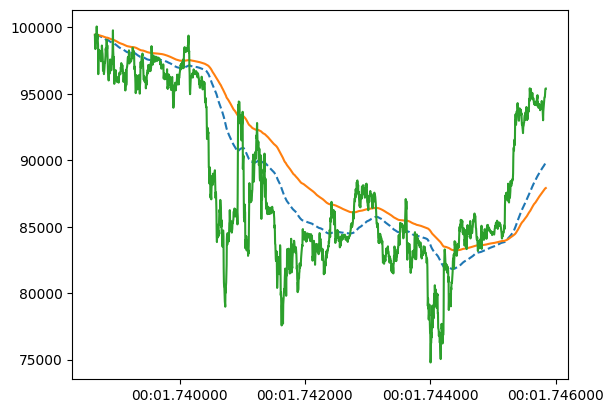

In [ ]:

# keep it for test
url=url2
data=fetch_OHLCV(url)

a=techmethods().calculate_ema(data['Close'],window=350)
b=techmethods().calculate_kama(data['Close'],fast_ema=50)
plt.plot(a,linestyle='--',label='ema')
plt.plot(b,label='kama')
plt.plot(data['Close'])
plt.show()


trend_bullish:   buy: False sell:   True
rsi:   buy>>> False Sell>>>:  False
macd condition:   buy>>> False | Sell>>>:    True
volume_condition:   buy>>> True | Sell>>>:    False
fib_condition:   buy>>> False | Sell>>>:    False
squeeze_condition:   buy>>> False
final>> False
informations>>> RSI: 46.097286862215086 Price: 95375.1
Current Trading Signal: HOLD
Recommended Position Size: 1.44 % of shares


/tmp/ipykernel_1737/2593622523.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0,1].plot(prices.index[-1],trading_system.rsi[-1], color='red', marker='o',markersize=8, markeredgecolor='black', markerfacecolor='white',  linestyle='', label='last_Price')


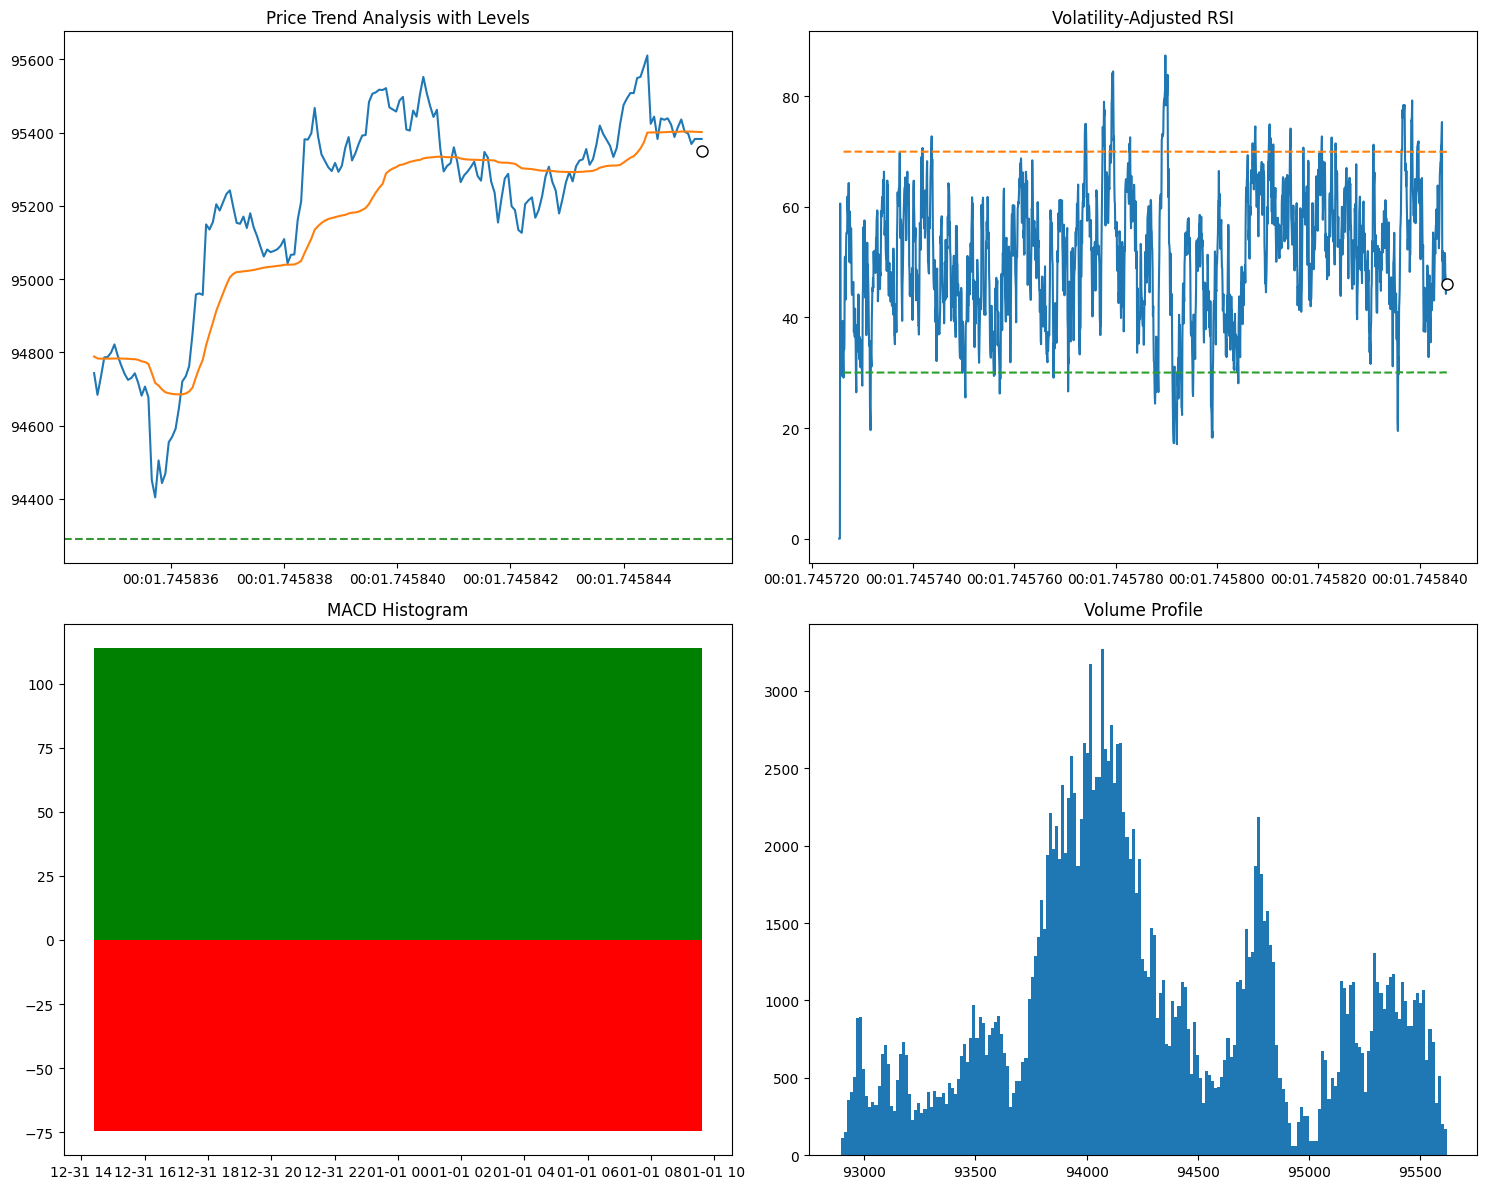

In [ ]:
url=url2
# ='https://data-api.coindesk.com/index/cc/v1/historical/minutes?market=cadli&instrument=BNX-USDT&limit=400&aggregate=5&fill=true&apply_mapping=true&response_format=JSON'
urlp='https://min-api.cryptocompare.com/data/price?fsym=BTC&tsyms=USD'
data=fetch_OHLCV(url3)

class strategy():
    def __init__(self):

        pass

    def first_strategy(self,data,urlp,plot_window: int = 180):

        # data=fetch_OHLCV(url)
        trading_system=TradingSystem(data['Close'],data,data['Volume'])








        model=MarketStructureAnalyzer(fractal_period=17,
                merge_tolerance_pct=0.6952,
                fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
                                )

        model2=techmethods()
        kama=model2.calculate_kama(data['Close'],fast_ema=5)



        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        account_size = 100000  # $100,000
        prices=data['Close']
        position_size = model2.calculate_position_size(account_size, prices)
        percent=position_size/account_size
        bin_centers,volumes=model.calculate_volume_profile(data)


        clear_output(wait=True)
        signal = trading_system.generate_signal(urlp)
        print(f"Current Trading Signal: {signal}")
        print(f"Recommended Position Size: {percent:0.2f} % of shares")

        # Volume pfofile
        axs[1,1].bar(bin_centers,volumes,width=np.diff(bin_centers, prepend=bin_centers[0]))
        axs[1,1].set_title("Volume Profile")


        # levels

        levels = model.calculate_levels(data)
        last_result=levels
        price=fetch_last_price(urlp)
        a=last_result['price'][last_result['price']> price]
        b=last_result['price'][last_result['price']< price]

        # print(f'The price {price} is between {b.iloc[-1]} and {a.iloc[0]}  ')
        # print(f'If break resistance level, next target is {a.iloc[1]}')
        # print(f'If break support level, next target is {b.iloc[-2]}')

        # Price plot

        plot_window: int = 180
        # axs[0,0].plot(df['Close'].iloc[-days_window:], color='royalblue', lw=1.5, label='Price')
        axs[0,0].plot(prices.index[-1],fetch_last_price(urlp), color='red', marker='o',markersize=8, markeredgecolor='black', markerfacecolor='white',  linestyle='', label='last_Price')
               # Price and KAMA
        axs[0,0].plot(prices.iloc[-plot_window:], label='Price')
        axs[0,0].plot(kama.iloc[-plot_window:], label='KAMA')
        axs[0,0].set_title('Price Trend Analysis with Levels')



                # Support/resistance zones
        for _, row in levels.iterrows():
                color = 'forestgreen' if row['type'] == 'support' else 'firebrick'
                alpha = pow(row['strength'],1.2) * 0.9
                axs[0,0].axhline(row['price'], color=color, linestyle='--', alpha=alpha,
                        label=f"{row['type'].title()} , strength: {round(row['strength'],2)}")





        # RSI and Bands
        axs[0,1].plot(trading_system.rsi, label='RSI')
        axs[0,1].plot(trading_system.rsi_upper, linestyle='--', label='Upper Band')
        axs[0,1].plot(trading_system.rsi_lower, linestyle='--', label='Lower Band')
        axs[0,1].plot(prices.index[-1],trading_system.rsi[-1], color='red', marker='o',markersize=8, markeredgecolor='black', markerfacecolor='white',  linestyle='', label='last_Price')

        axs[0,1].set_title('Volatility-Adjusted RSI')

        # MACD Histogram
        axs[1,0].bar(prices.index, trading_system.histogram,
                color=np.where(trading_system.histogram > 0, 'g', 'r'))
        axs[1,0].set_title('MACD Histogram')

        plt.tight_layout()
        plt.show()


strategy().first_strategy(data=data,urlp=urlp,plot_window=200)

<h2> Strategy Class
<h4> Different Strategies That Should Be Implemented